# Hyperparameter analysis in BTW model

The purpose of this notebook is to find out the effect of hyperparameter $a$ on the quality of predictions. Obviously, the larger hyperparameter $a$ means the larger the memory in AR(1) process. 

Let's calculate time when the forecast will contribute less than 1 to the decision variable:

$$ a^n \cdot s < 1$$

Under the assumption $a(L) = e^{-\frac{1}{T(L)}}$:

$$ e^{-\frac{n}{T(L)}} < 1 $$

Consequently:

$$ n > \ln s \cdot T(L) $$

In BTW model $s < L^3$, so in the worst case:

$$ n > 3 \ln L \cdot T(L) $$

However, this is a very strange result. In [Hallerberg et al.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.026124), $T(L)$ doubled when the $L$ doubled. This means that the memory of the AR(1) model also doubled.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

import sys
sys.path.insert(1, 'src/')

In [2]:
# import abel_heap
# import numpy as np

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd
from utils import *

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 36
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.minor.pad'] = 15
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['ytick.minor.pad'] = 15
plt.rcParams['ytick.major.pad'] = 15

## Previous scaling

$$ \eta = p \cdot s_{\max}, $$

where $s_{\max} = \frac{L(L+1)(L+2)}{6}$. And predict probability of events:

$$ s_i > \eta $$

In [3]:
get_eta_determ = lambda L, percent: int(L * (L+1) * (L+2) // 6 * percent)
get_a = lambda T: np.exp(-1. / T)

PERCENTS_ETA = [0.10, 0.15, 0.2, 0.25, 0.30]
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

args = []
for L in LS:
    for T in TS:
        A = get_a(T)
        for percent in PERCENTS_ETA:
            model = "determ"
            ETA = get_eta_determ(L, percent)
            args.append((L, ETA, A, model))

abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=7)
auc_curve_determ = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=7)

# calculate some useful columns

auc_curve_determ["eps"] = auc_curve_determ["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)

A2T = {}
for T in TS:
    A2T[get_a(T)] = T
auc_curve_determ["T"]  = auc_curve_determ["A"].apply(lambda x: A2T[x])

EtaL2percent = {}
for L in LS:
    for percent in PERCENTS_ETA:
        EtaL2percent[(get_eta_determ(L, percent), L)] = percent

percents = []
for _, row in auc_curve_determ.iterrows():
    percents.append(str(int(EtaL2percent[(row["ETA"], row["L"])] * 100)) + "% $s_{max}$")
auc_curve_determ["$\eta$"] = percents

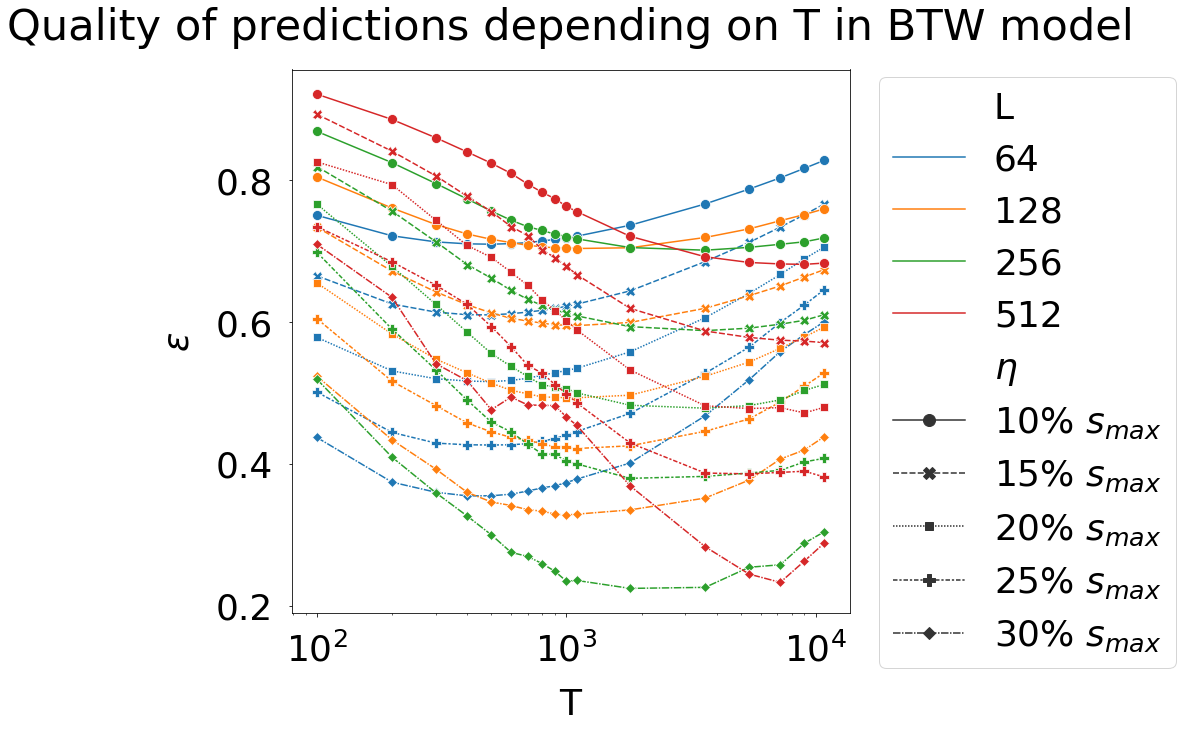

In [4]:
sns.lineplot(data=auc_curve_determ, x="T", y="eps", hue="L", style="$\eta$", markers=True, palette="tab10", markersize=10)
plt.title("Quality of predictions depending on T in BTW model")
plt.xlabel("T")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

### Short analysys

We see that doubling $T(L)$ is not an ideal strategy, and there are also problems with scaling, which deteriorates on large $L$. In part, this can be explained by the small predicted development of events.

## New scaling

Let's try to find optimal $\gamma$ for the following scaling:

$$ \eta = p \cdot L^{\gamma} $$

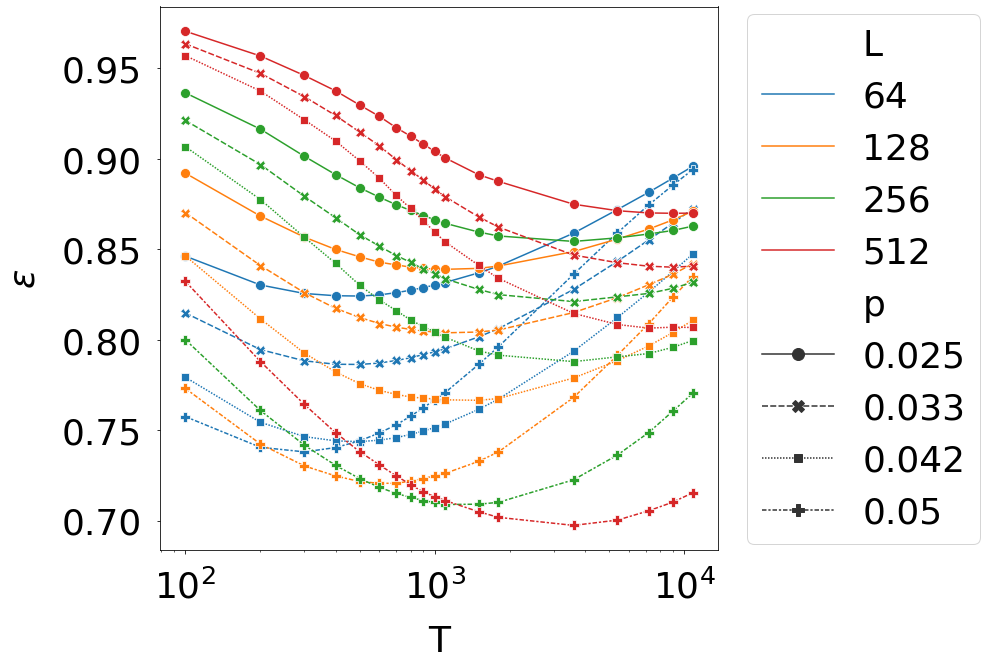

In [5]:
gamma = 2.75

# PERCENTS_ETA = [0.15 / 6 , 0.2 / 6, 0.25 / 6, 0.30 / 6]
PERCENTS_ETA = [0.025, 0.033, 0.042, 0.05] # approx of above line
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

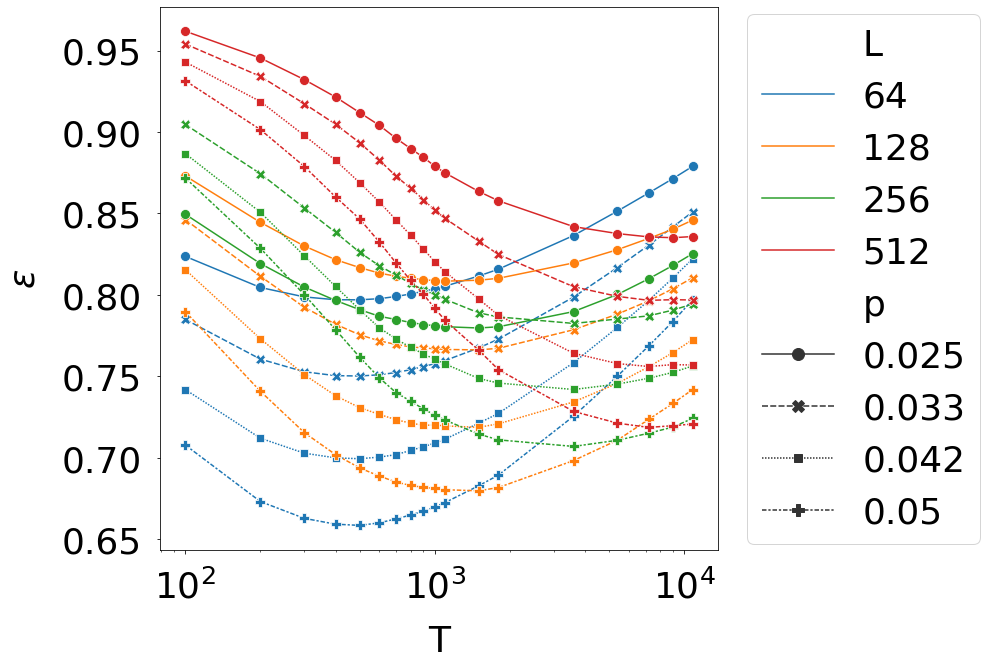

In [6]:
gamma = 2.8

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

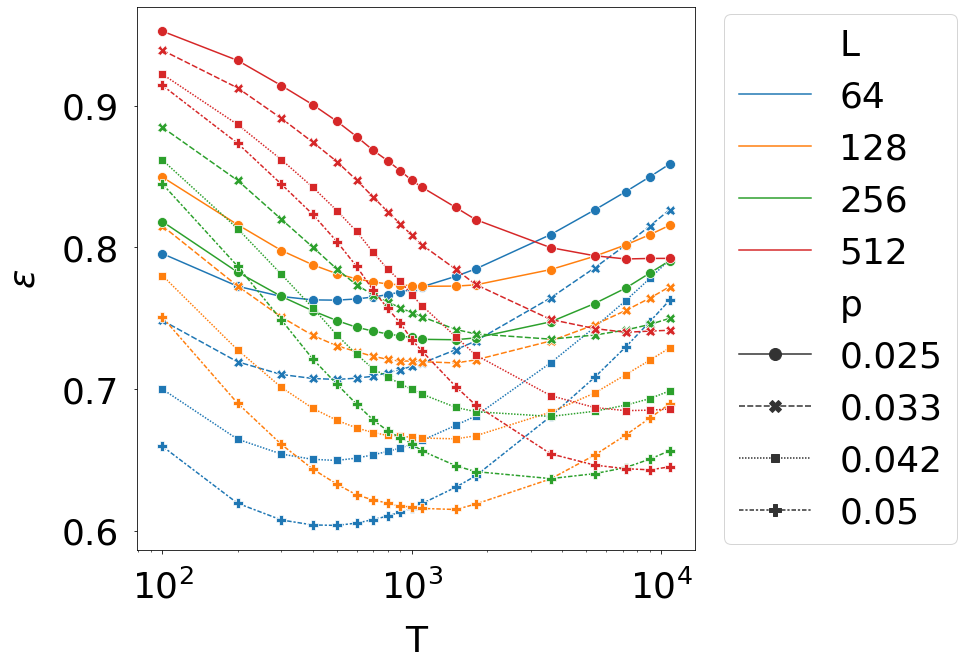

In [7]:
gamma = 2.85

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

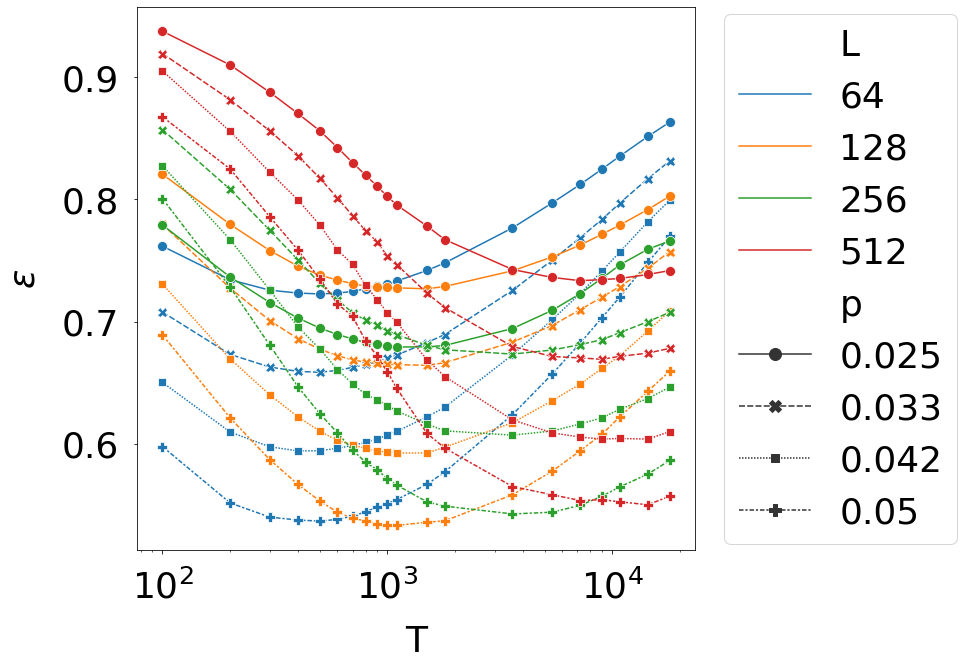

In [8]:
gamma = 2.9

TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6, 1800*8, 1800*10]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

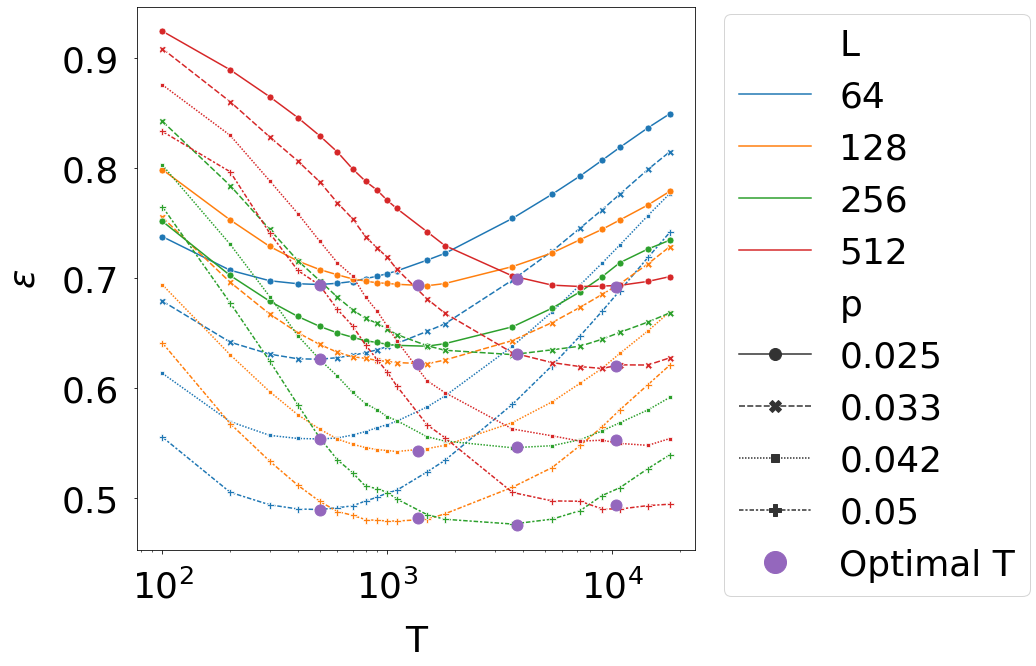

In [16]:
gamma = 2.93

# PERCENTS_ETA = [0.15 / 6 , 0.2 / 6, 0.25 / 6, 0.30 / 6]
PERCENTS_ETA = [0.025, 0.033, 0.042, 0.05] # approx of above line
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6, 1800*8, 1800*10]
auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
# plot_global_auc_curves(auc_curve, gamma)

sns.lineplot(data=auc_curve, x="T", y="eps", hue="L", style="p", markers=True, palette="tab10", markersize=7)

TS = [500, int(500 * 2.75), int(500 * 2.75**2), int(500*2.75**3)]
roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7, grid=False)
opt_metric = roc_curve.copy().reset_index()
#opt_metric["p"] = opt_metric["p"].astype(float)
#event_rate = calculate_event_rate(gamma, PERCENTS_ETA, LS, "determ")
#opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

for i, row in opt_metric.iterrows():
    plt.plot(row["T"], row["eps"], "ro", label="Optimal T" if i == 0 else "", markersize=11, color="tab:purple")

str_gamma = "{" + f"{gamma:.3}" + "}"
plt.xlabel("T")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.plot()
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

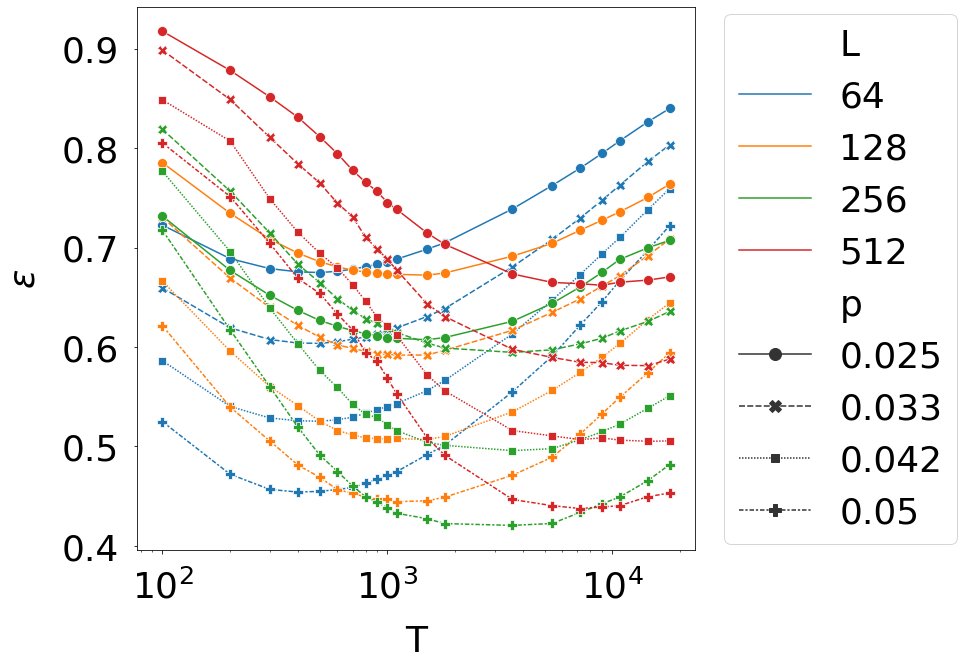

In [10]:
gamma = 2.95

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

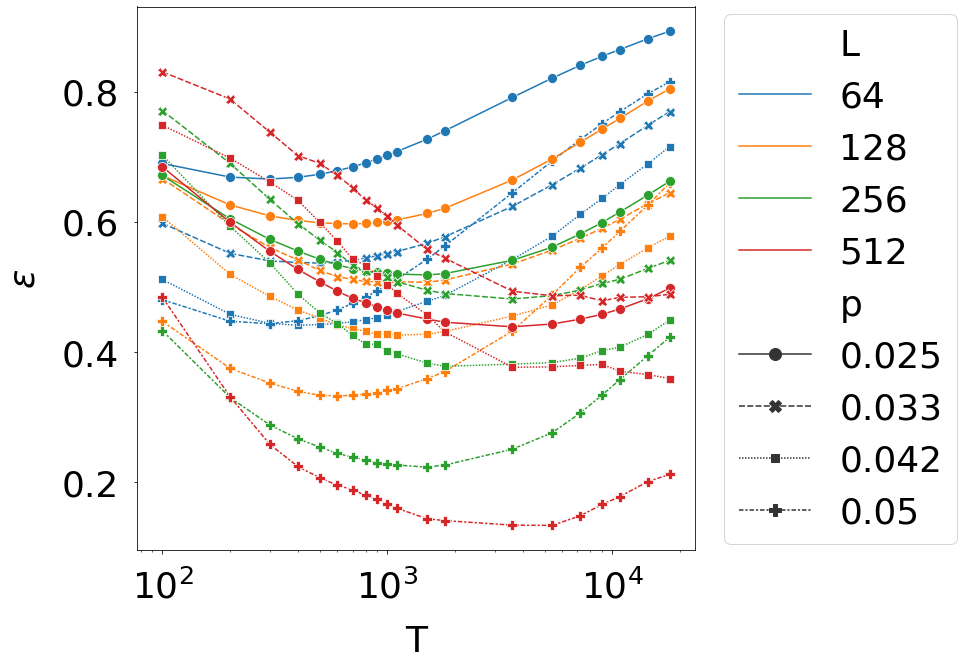

In [9]:
gamma = 3.0

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

## Find an optimal T(L)

Let's see on the optimal $T(L)$ for different $\gamma$

### Local trands

Let's try to find a better parameter using a local plot

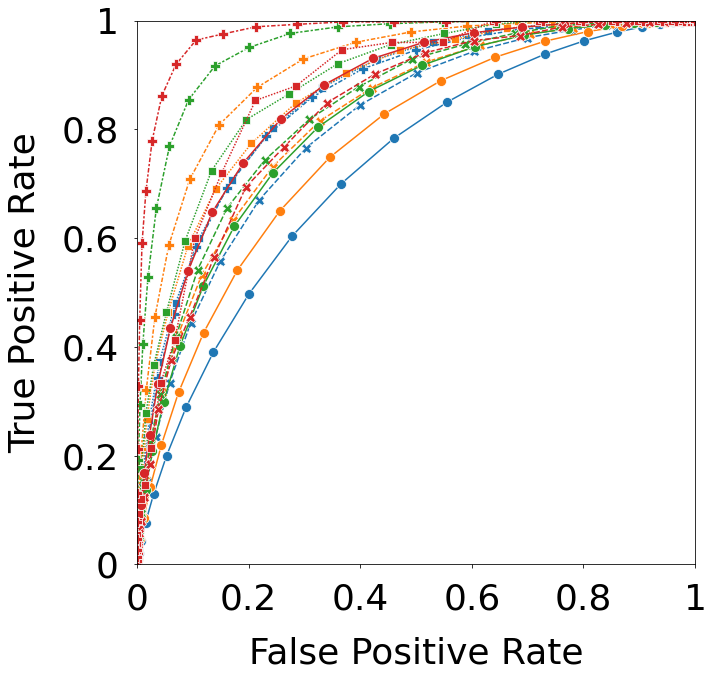

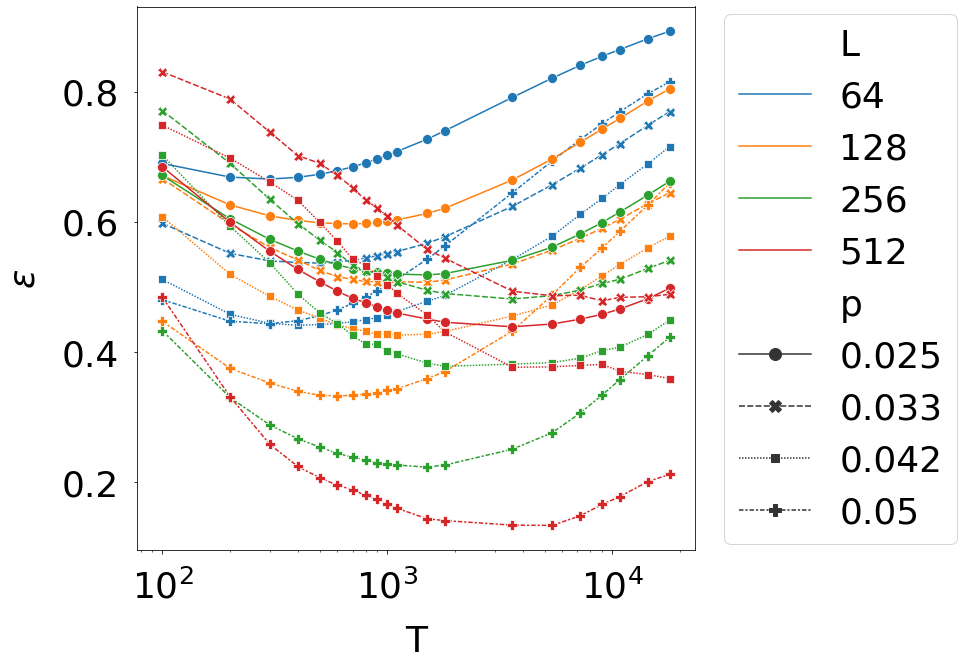

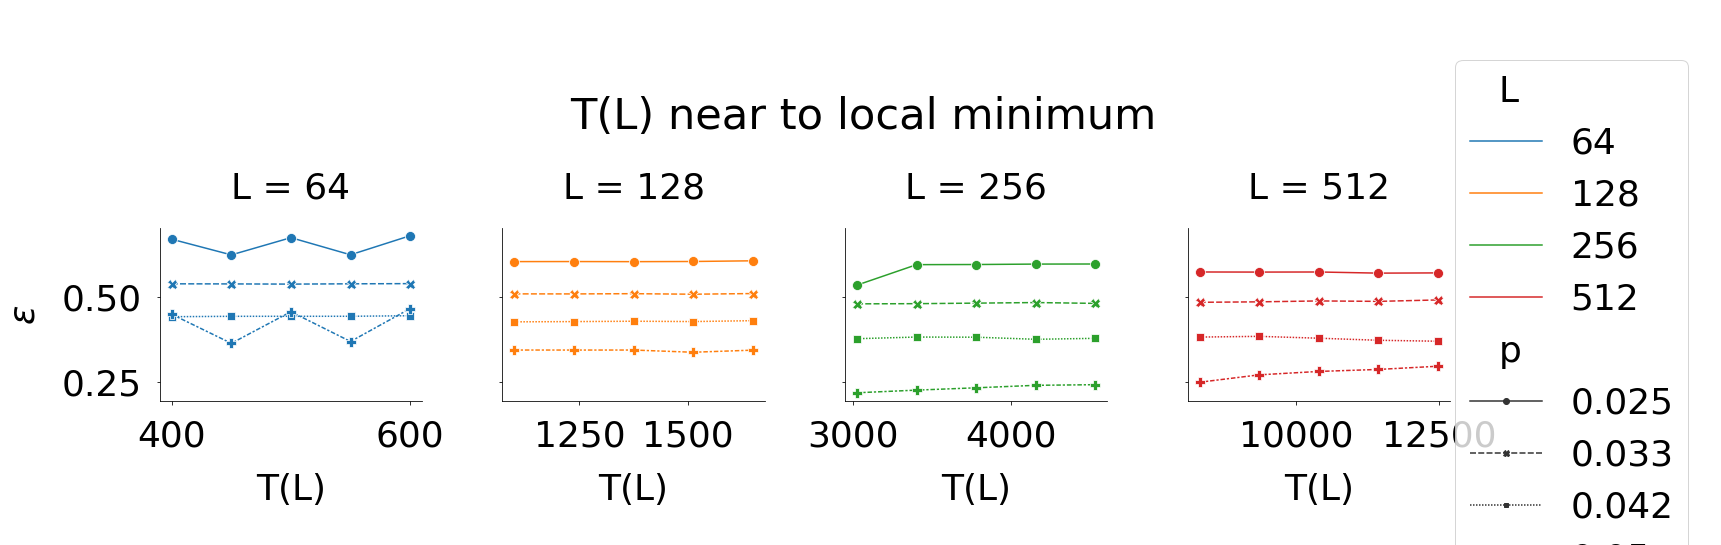

In [11]:
gamma = 3.0
t_scaling = 2.75
TS_local = [400, 450, 500, 550, 600]
TS_global = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6, 1800*8, 1800*10]

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "determ")

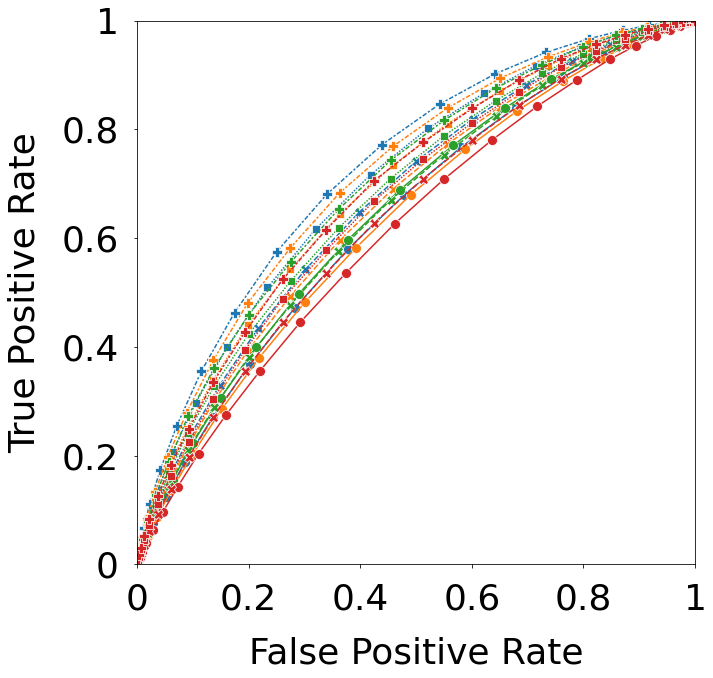

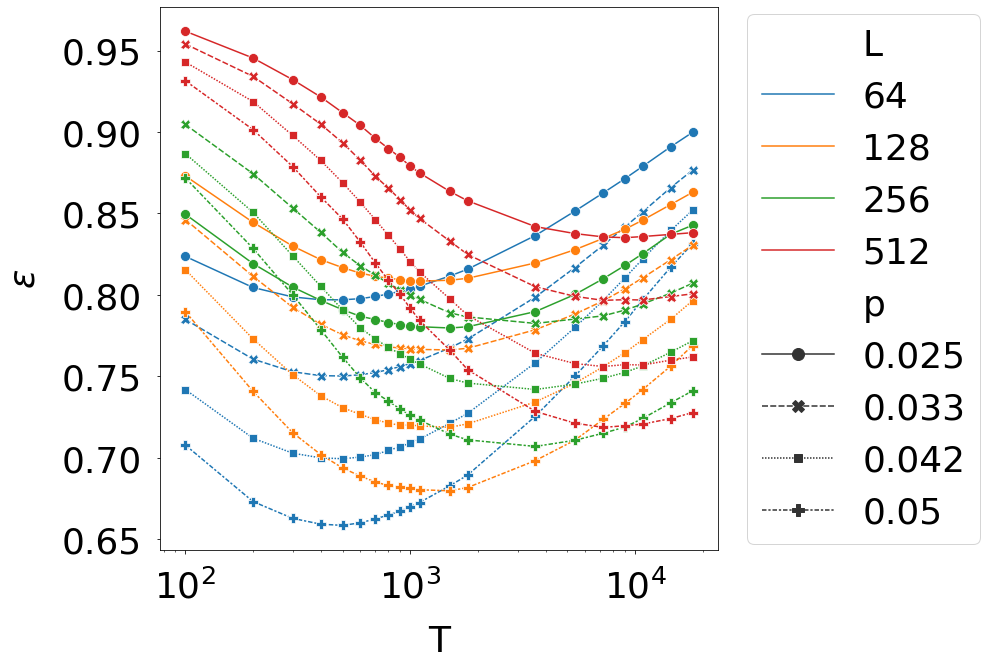

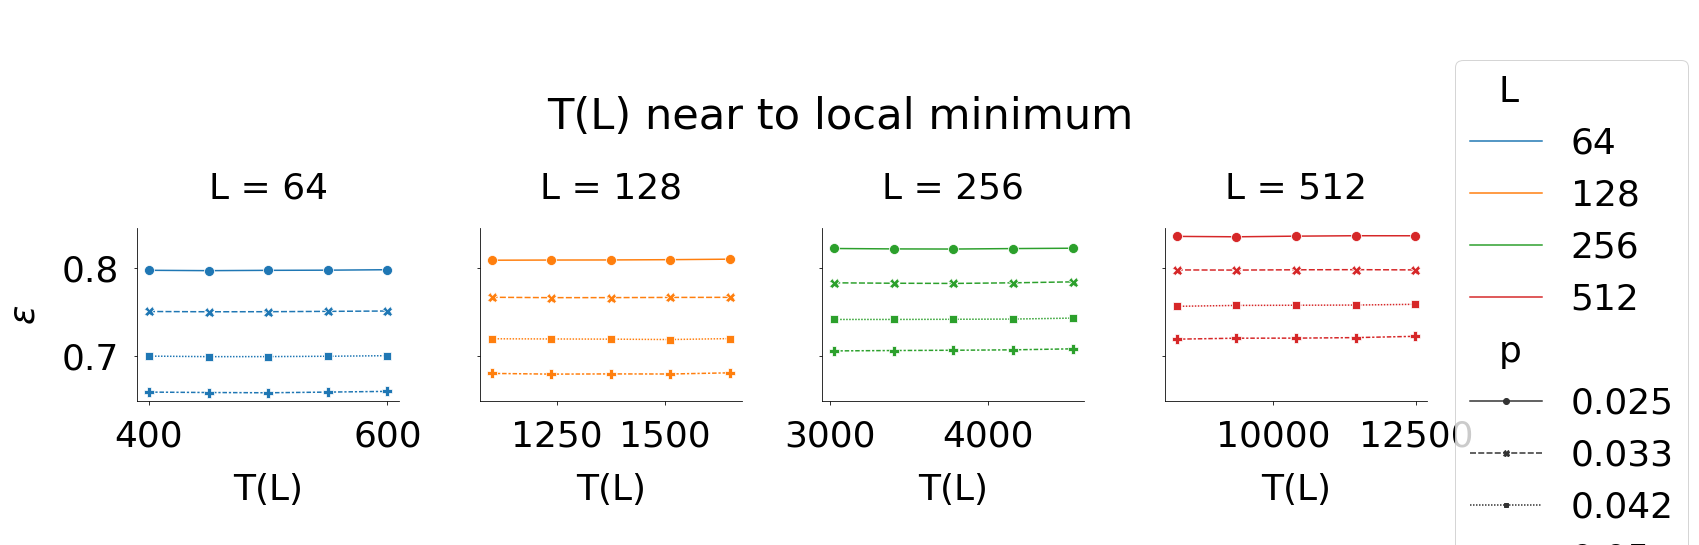

In [15]:
gamma = 2.8
plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "determ")

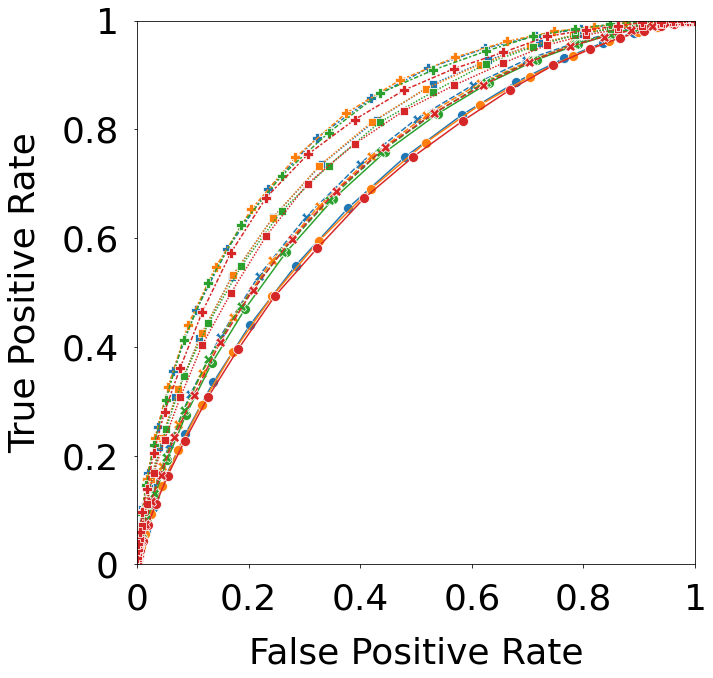

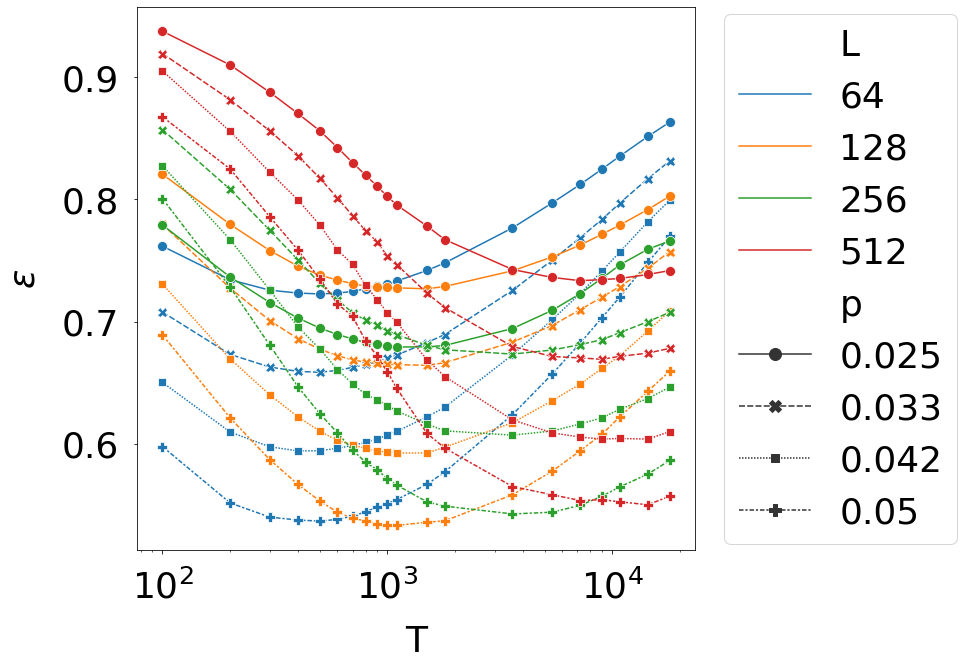

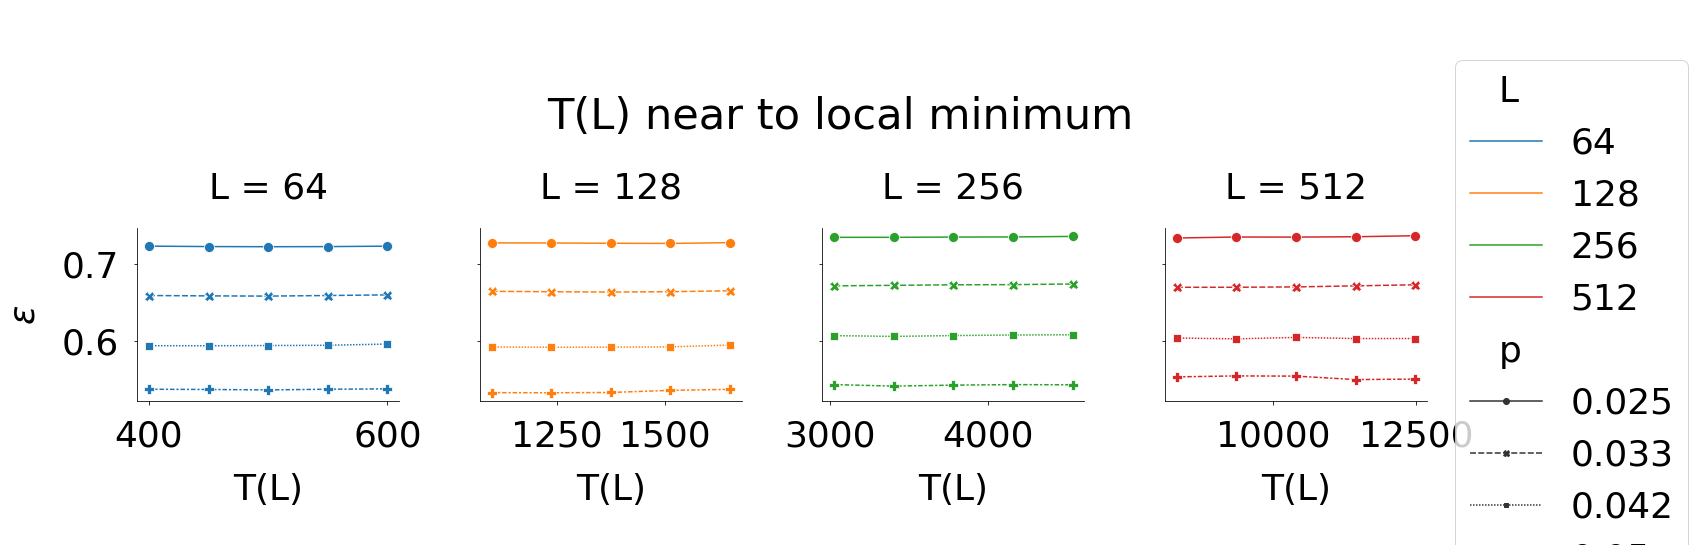

In [16]:
gamma = 2.9
plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "determ")

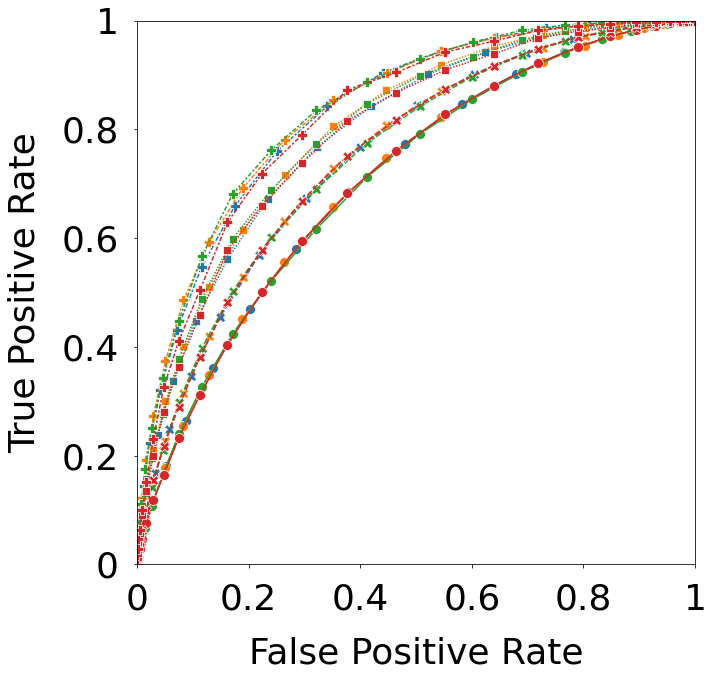

In [17]:
gamma = 2.93
# plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "determ")

PERCENTS_ETA = [0.025, 0.033, 0.042, 0.05]
LS = [64, 128, 256, 512]
TS = [500, int(500 * 2.75), int(500 * 2.75**2), int(500*2.75**3)]

roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7, grid=False)
opt_metric = roc_curve.copy().reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
# event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "rand")
# opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

plot_auc_curve(opt_metric)

We can see that $T(L) = 2.75^{\log_{2}\frac{L}{64}} \cdot 500$ shows good results. But the graph for large fields is fluctuated for small $p$.

### Statistics for optimal $\gamma$ and $T(L)$

Statistically prove that we have chosen the optimal parameters.

In [383]:
t_scaling = 2.75
best_t = 500

TS = [best_t, int(best_t * t_scaling), int(best_t * t_scaling**2), int(best_t*t_scaling**3)]
gammas = [2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96]

args = []
add_t = []
add_p = []
add_gamma = []

for percent in PERCENTS_ETA:
    for gamma in gammas:
        for T, L in zip(TS, LS):
            ETA = int(L**gamma * percent)
            A = np.exp(-1. / T)
            args.append((L, ETA, A, "determ"))
            add_t.append(T)
            add_p.append(percent)
            add_gamma.append(gamma)

abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=7)
auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=7)

auc_curve["p"] = add_p
auc_curve["T"] = add_t
auc_curve["gamma"] = add_gamma
auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)

In [384]:
#var = auc_curve.groupby(["p", "gamma"])["eps"].var().groupby("gamma").mean().rename("var")
var = auc_curve.groupby(["p", "gamma"])["eps"].var().rename("var").reset_index()

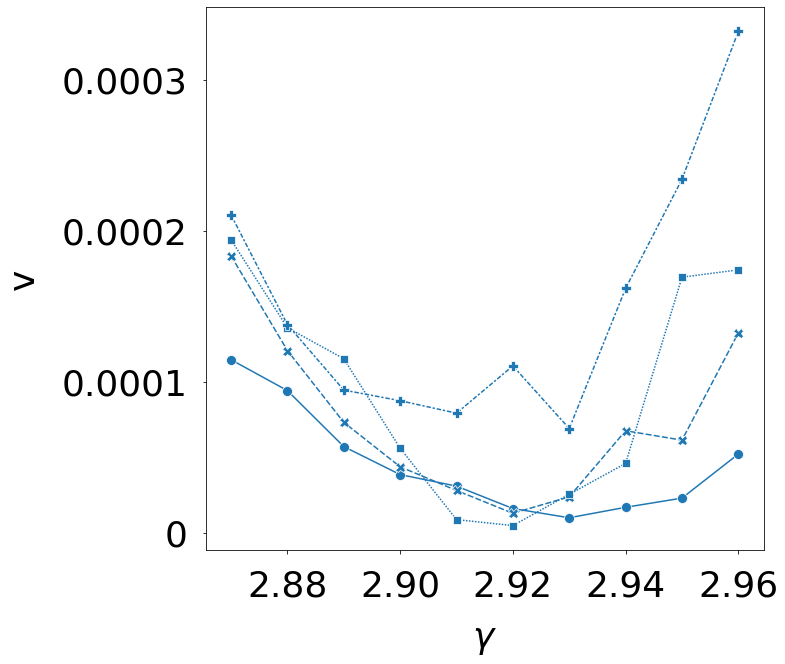

In [389]:
sns.lineplot(data=var, x="gamma", y="var", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("v")
#plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.yticks([0, 0.0001, 0.0002, 0.0003], [0, 0.0001, 0.0002, 0.0003])
plt.xlabel("$\gamma$")
plt.show()

In [390]:
from sklearn.linear_model import LinearRegression
from collections import defaultdict

gamma2coef = defaultdict(list)
absolute_coef = defaultdict(list)

for k, v in auc_curve.groupby(["gamma", "p"]):
    linreg = LinearRegression()
    y = v["eps"]
    X = np.array(v["T"]).reshape(y.shape[0], 1)
    linreg = linreg.fit(X, y)
    
    gamma2coef[k[0]].append(linreg.coef_[0])
    
    absolute_coef["gamma"].append(k[0])
    absolute_coef["p"].append(k[1])
    absolute_coef["absolute_coef"].append(np.abs(linreg.coef_[0]))
    
absolute_coef = pd.DataFrame(data=absolute_coef)

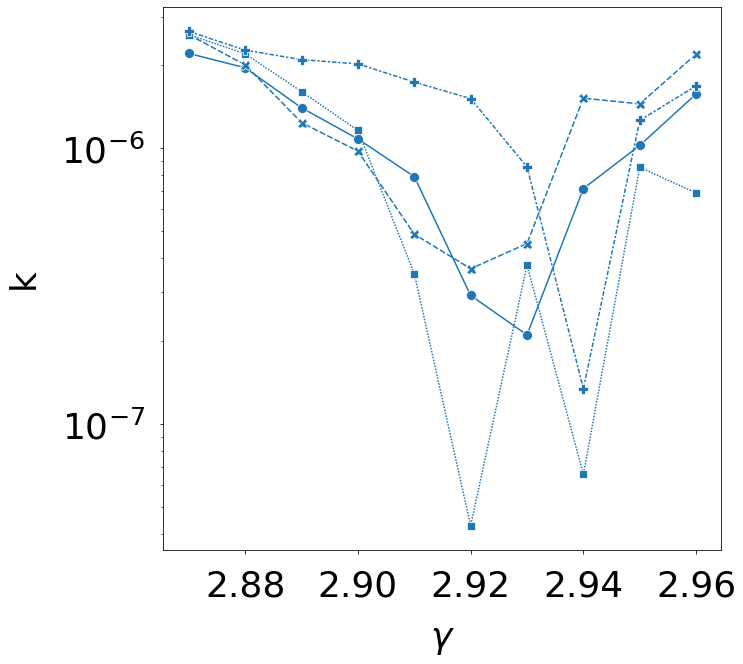

In [391]:
sns.lineplot(data=absolute_coef, x="gamma", y="absolute_coef", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("k")
plt.yscale("log")
plt.xlabel("$\gamma$")
plt.show()

In [357]:
from shapely.geometry import Polygon
from IPython.display import display
from copy import deepcopy

def calculate_IoU_fixed_gamma(data):
    IoU = {}
    for p, by_p in data.groupby(["p"]):
        unions, intersects = None, None
        for L, by_p_l in by_p.groupby(["L"]):
            fpr = by_p_l["fpr"].iloc[0]
            tpr = by_p_l["tpr"].iloc[0]
            polygon = Polygon([(x, y) for x, y in zip(fpr, tpr)] + [(1, 0)])
            if unions is None:
                unions = deepcopy(polygon)
                intersects = deepcopy(polygon)
            else:
                intersects = intersects.intersection(polygon)
                unions = unions.union(polygon)
        
        IoU[p] = intersects.area / unions.area
        
    return IoU

def calculate_IoU(data):
    results = defaultdict(list)
    for gamma, by_gamma in data.groupby(["gamma"]):
        IoU_gamma = calculate_IoU_fixed_gamma(by_gamma)
        results["p"] += IoU_gamma.keys()
        results["IoU"] += IoU_gamma.values()
        results["gamma"] += [gamma] * len(IoU_gamma)
    return pd.DataFrame(data=results)

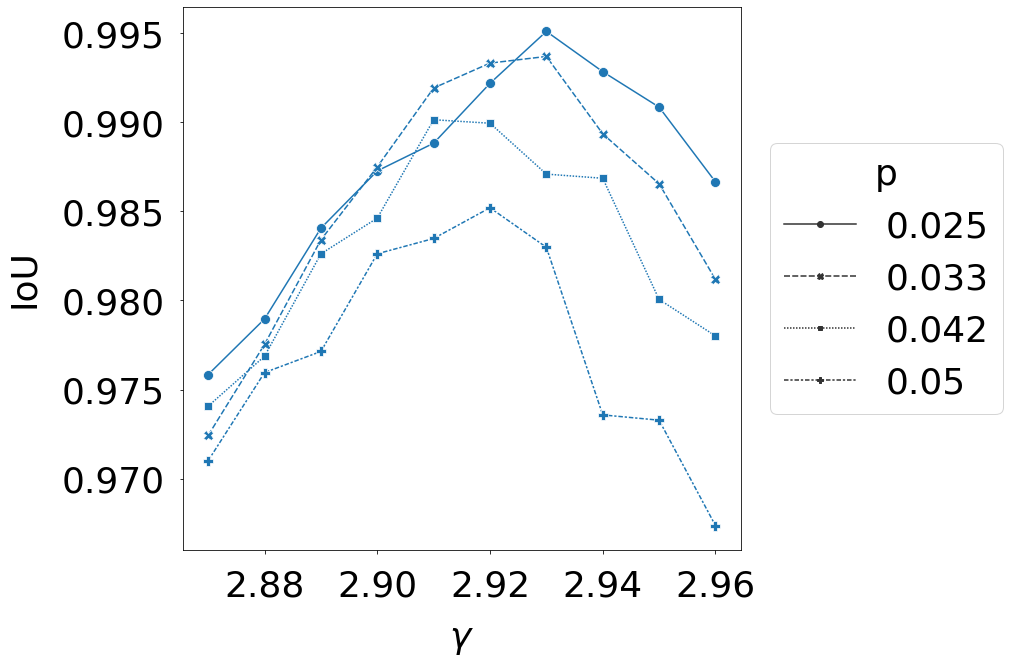

In [392]:
IoU = calculate_IoU(auc_curve)
sns.lineplot(data=IoU, x="gamma", y="IoU", style="p", markers=True, palette="tab10", markersize=10)
#plt.yscale("log")
plt.legend(bbox_to_anchor=[1.02, 0.5], loc='center left', title="p")
plt.xlabel("$\gamma$")
plt.show()

In [3]:
gamma = 2.99
PERCENTS_ETA_EXTENDED = [0.01 / 6, 0.05 / 6, 0.1 / 6, 0.15 / 6, 0.2 / 6, 0.25 / 6, 0.3 / 6, 0.35 / 6, 0.4 / 6, 0.45 / 6, 0.5 / 6]
LS = [64, 128, 256, 512]
TS = [500, int(500 * 2.75), int(500 * 2.75**2), int(500*2.75**3)]

roc_curve = calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "determ", njobs=7, min_event_rate=1e-7, grid=False)

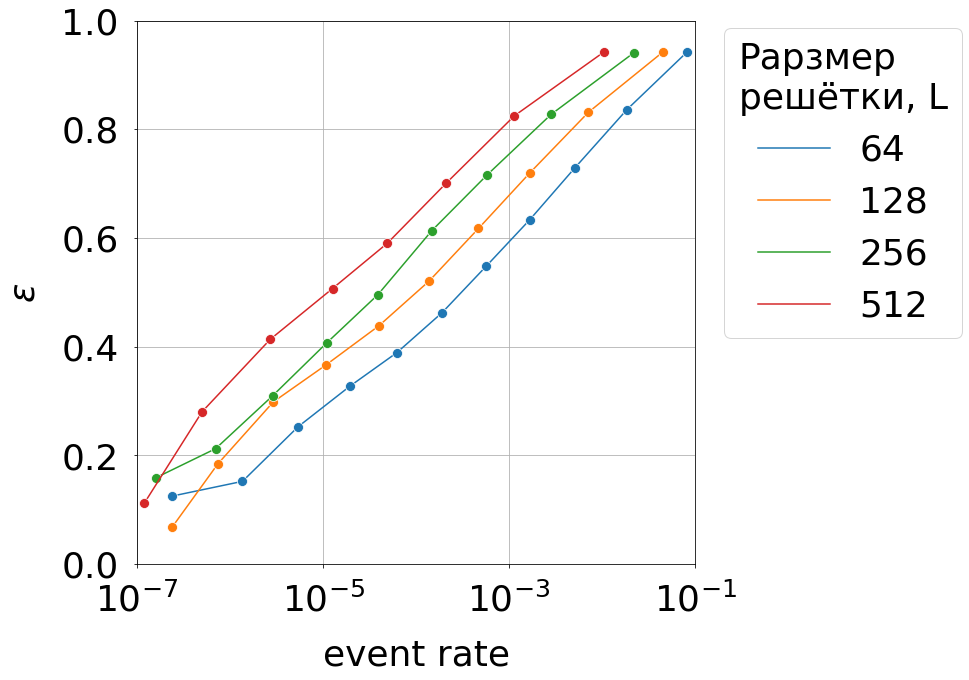

In [4]:
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", style="p", size="gamma", markers=True, palette="tab10", s=300)
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", s=300)
sns.lineplot(data=roc_curve, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

# plt.title(f"Quality of predictions depending on event rate in BTW model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
plt.grid(True)
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
legend = plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
legend.set_title("Рарзмер\nрешётки, L") 
plt.show()

In [31]:
roc_curve[roc_curve["L"] == 512]["normalized_s"].max()

0.08481505374549822

In [34]:
roc_curve["event_rate"]*50_000_000

0     4108503.0
1      918083.0
2      255770.0
3       83323.0
4       28212.0
5        9506.0
6        3118.0
7         969.0
8         269.0
9          68.0
10         12.0
11    2243021.0
12     356943.0
13      83732.0
14      23439.0
15       6876.0
16       1996.0
17        542.0
18        146.0
19         37.0
20         12.0
21    1106017.0
22     141536.0
23      29240.0
24       7397.0
25       1932.0
26        546.0
27        143.0
28         35.0
29          8.0
30     528055.0
31      57000.0
32      10486.0
33       2458.0
34        632.0
35        135.0
36         25.0
37          6.0
Name: event_rate, dtype: float64

In [35]:
roc_curve["L"]

0      64
1      64
2      64
3      64
4      64
5      64
6      64
7      64
8      64
9      64
10     64
11    128
12    128
13    128
14    128
15    128
16    128
17    128
18    128
19    128
20    128
21    256
22    256
23    256
24    256
25    256
26    256
27    256
28    256
29    256
30    512
31    512
32    512
33    512
34    512
35    512
36    512
37    512
Name: L, dtype: int64

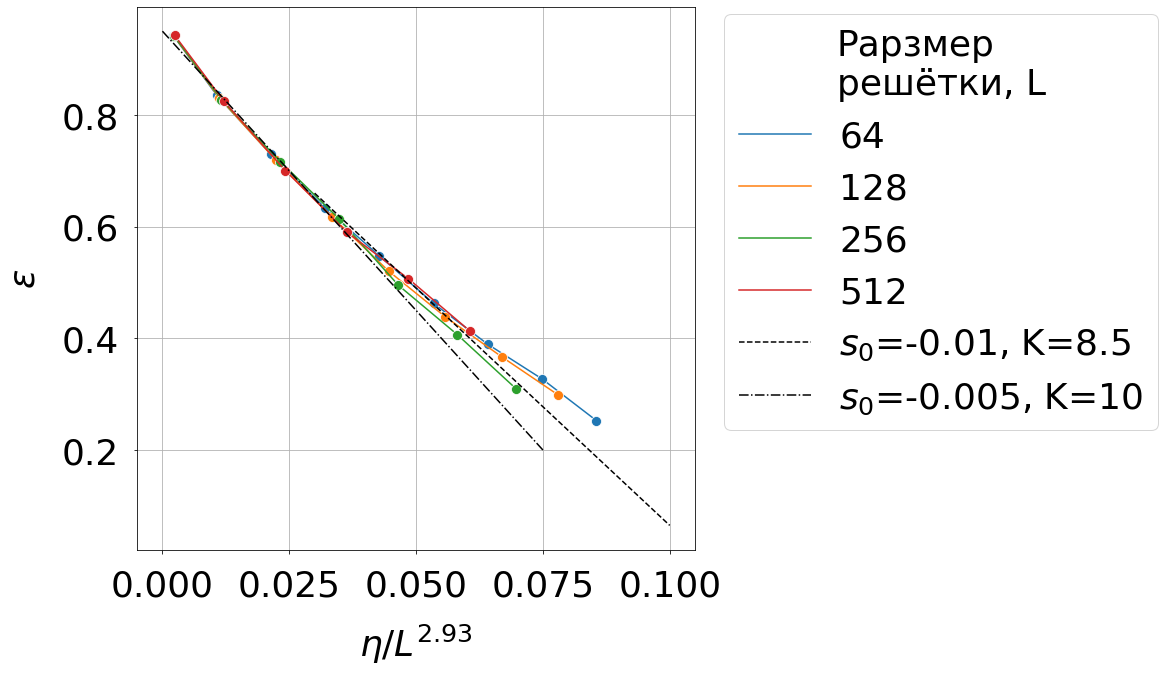

In [41]:
roc_curve["normalized_s"] = roc_curve["ETA"] / roc_curve["L"]**2.93
numer_of_events = roc_curve["event_rate"]*50_000_000

sns.lineplot(data=roc_curve[numer_of_events > 100], x="normalized_s", y="eps", hue="L", marker="o", palette="tab10", markersize=10)
plt.xlabel(r"$\eta / L^{2.93}$")
plt.ylabel("$\epsilon$")
#plt.xscale("log")
#plt.ylim([0, 1])
plt.grid(True)

#s0, K = -0.005, 10
#x = [0, 0.075]

s0, K = -0.01, 8.5
x = [0.03, 0.1]
y = [1 - (xi - s0) * K for xi in x]
plt.plot(x, y, color="black", linestyle="--", label=f"$s_0$={s0}, K={K}")

s0, K = -0.005, 10
x = [0, 0.075]
y = [1 - (xi - s0) * K for xi in x]
plt.plot(x, y, color="black", linestyle="-.", label=f"$s_0$={s0}, K={K}")

#plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
#plt.xscale("log")
#plt.yscale("log")
legend = plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
legend.set_title("Рарзмер\nрешётки, L") 
plt.show()